# PixelCNN for FashionMNIST

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/05_autoregressive/02_pixelcnn/pixelcnn.ipynb)

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

import jax
import jax.numpy as jnp

from flax import linen as nn
from flax.training import train_state

import optax

## 0. Training Parameters

In [2]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 8
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 64
EPOCHS = 100

## 1. Preparing FashionMNIST dataset

In [81]:
# Turn input image into pixels and per-pixel labels
def preprocess(imgs):
    imgs = imgs['image']
    imgs_int = tf.image.resize(imgs, (IMAGE_SIZE, IMAGE_SIZE))
    imgs_int = tf.cast((imgs_int / (256 / PIXEL_LEVELS)), tf.int32)
    imgs = tf.cast(imgs_int, tf.float32)
    imgs = imgs / PIXEL_LEVELS
    return {'image': imgs, 'label': imgs_int}

# Get train/valid datasets
def get_datasets():
    train_ds, valid_ds = tfds.load('fashion_mnist', split=['train', 'test'])
    
    train_ds = train_ds.map(lambda sample: preprocess(sample))
    valid_ds = valid_ds.map(lambda sample: preprocess(sample))
    
    train_ds = train_ds.shuffle(1024).batch(BATCH_SIZE).prefetch(1)
    valid_ds = valid_ds.batch(BATCH_SIZE).prefetch(1)
    return train_ds, valid_ds

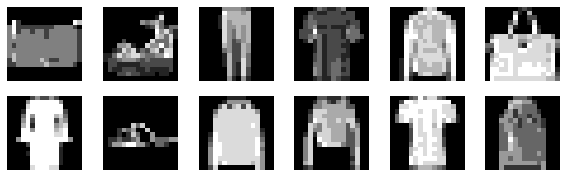

In [86]:
# Check dataset
def plot_imgs(batch, num_rows=2, num_cols=6):
    plt.figure(figsize=(10, 3))
    for i in range(num_cols * num_rows):
        ax = plt.subplot(num_rows, num_cols, i + 1)
        ax.axis('off')
        ax.imshow(batch[i], cmap='gray')
    plt.show()

test_ds, _ = get_datasets()
test_batch = next(test_ds.as_numpy_iterator())['image']
plot_imgs(test_batch)

## 2. Build the PixelCNN